In [1]:
import sys
import os

project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.append(project_root)

%load_ext autoreload
%autoreload 2


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from src.features import build_features

sns.set_style()
plt.rcParams["figure.figsize"] = (12, 6)

In [3]:
poblacion_teorica = pd.read_excel("../data/processed/proyeccion_problemas_de_salud.xlsx")

poblacion_teorica["Diagnostico"] = poblacion_teorica.Diagnostico.str.split().str[0]
poblacion_teorica = poblacion_teorica.query("Estrato == 'Pais'")

DIAGS_RELEVANTES = poblacion_teorica.Diagnostico.unique()
poblacion_teorica = poblacion_teorica.set_index("Diagnostico")
# Selecciona solamente la poblacion prevista
poblacion_teorica = poblacion_teorica[[i for i in range(2017, 2036)]]

In [4]:
egresos_int = pd.read_csv("../data/processed/egresos_torax_mes_y_dia.csv")
egresos_int = egresos_int[egresos_int["DIAG1"].isin(DIAGS_RELEVANTES)]
egresos_int = egresos_int.query("ANO_EGRESO >= 2017")

In [5]:
egresos_pais = pd.read_csv(
    "../data/processed/ranking_nacional_egresos.csv",
    sep=";",
    encoding="latin-1",
    usecols=[
        "ANO_EGRESO",
        "ESTABLECIMIENTO_SALUD",
        "DIAG1",
        "n_egresos",
        "dias_estada_totales",
        "n_int_q",
        "n_muertos",
    ],
)

egresos_pais = egresos_pais[egresos_pais["DIAG1"].isin(DIAGS_RELEVANTES)]
egresos_pais = egresos_pais.query("ANO_EGRESO >= 2017")

## Separación de población teórica en hospitalizados y ambulatorios

In [6]:
# De los casos totales, se asume que una parte (0.8) se resuelve en hospitalizacion
RATIO_HOSPITALIZADOS = 0.8
RATIO_AMBULATORIO = 1 - RATIO_HOSPITALIZADOS

poblacion_teorica_hospitalizados = poblacion_teorica * RATIO_HOSPITALIZADOS
poblacion_teorica_ambulatorio = poblacion_teorica * RATIO_AMBULATORIO

In [7]:
tabla_dinamica_egresos_pais = pd.pivot_table(
    egresos_pais,
    index="DIAG1",
    columns="ANO_EGRESO",
    values=["n_egresos"],
    aggfunc="sum",
    fill_value=0,
)

tabla_dinamica_egresos_int = pd.pivot_table(
    egresos_int,
    index="DIAG1",
    columns="ANO_EGRESO",
    values=["n_egresos"],
    aggfunc="sum",
    fill_value=0,
)

In [8]:
tabla_dinamica_egresos_pais.columns = tabla_dinamica_egresos_pais.columns.droplevel(0)
tabla_dinamica_egresos_int.columns = tabla_dinamica_egresos_int.columns.droplevel(0)

## Obtención de brecha de atención del país

En este apartado se quiere saber si el país ha suplido la necesidad de atención para cada problema
de salud. Para esto, se contrastará la cantidad de casos atendidos a nivel país en una hospitalización con
los casos teóricos según la incidencia. La fórmula será:

$ Brecha = \frac{Casos Atendidos Reales - Casos Teoricos}{Casos Teoricos}$

En el caso que la brecha sea positiva, entonces $Casos Atendidos Reales > Casos Teoricos$, y el pais
ha podido suplir la demanda sanitaria del problema de salud. En caso contrario, el país ha sido
incapaz de suplir la demanada para resolver estos problemas de salud. Además, se puede saber
el porcentaje de los casos teóricos que ha suplido el país. Por ejemplo:

$Brecha = 1.12$ Indica que el país ha resolvido todos los casos teóricos del problema de salud.
Además, ha resuelto un 12% más que los casos teóricos.

In [32]:
brecha_pais = (
    tabla_dinamica_egresos_pais - poblacion_teorica_hospitalizados.round(0)
) / poblacion_teorica_hospitalizados.round(0)

c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


<Axes: >

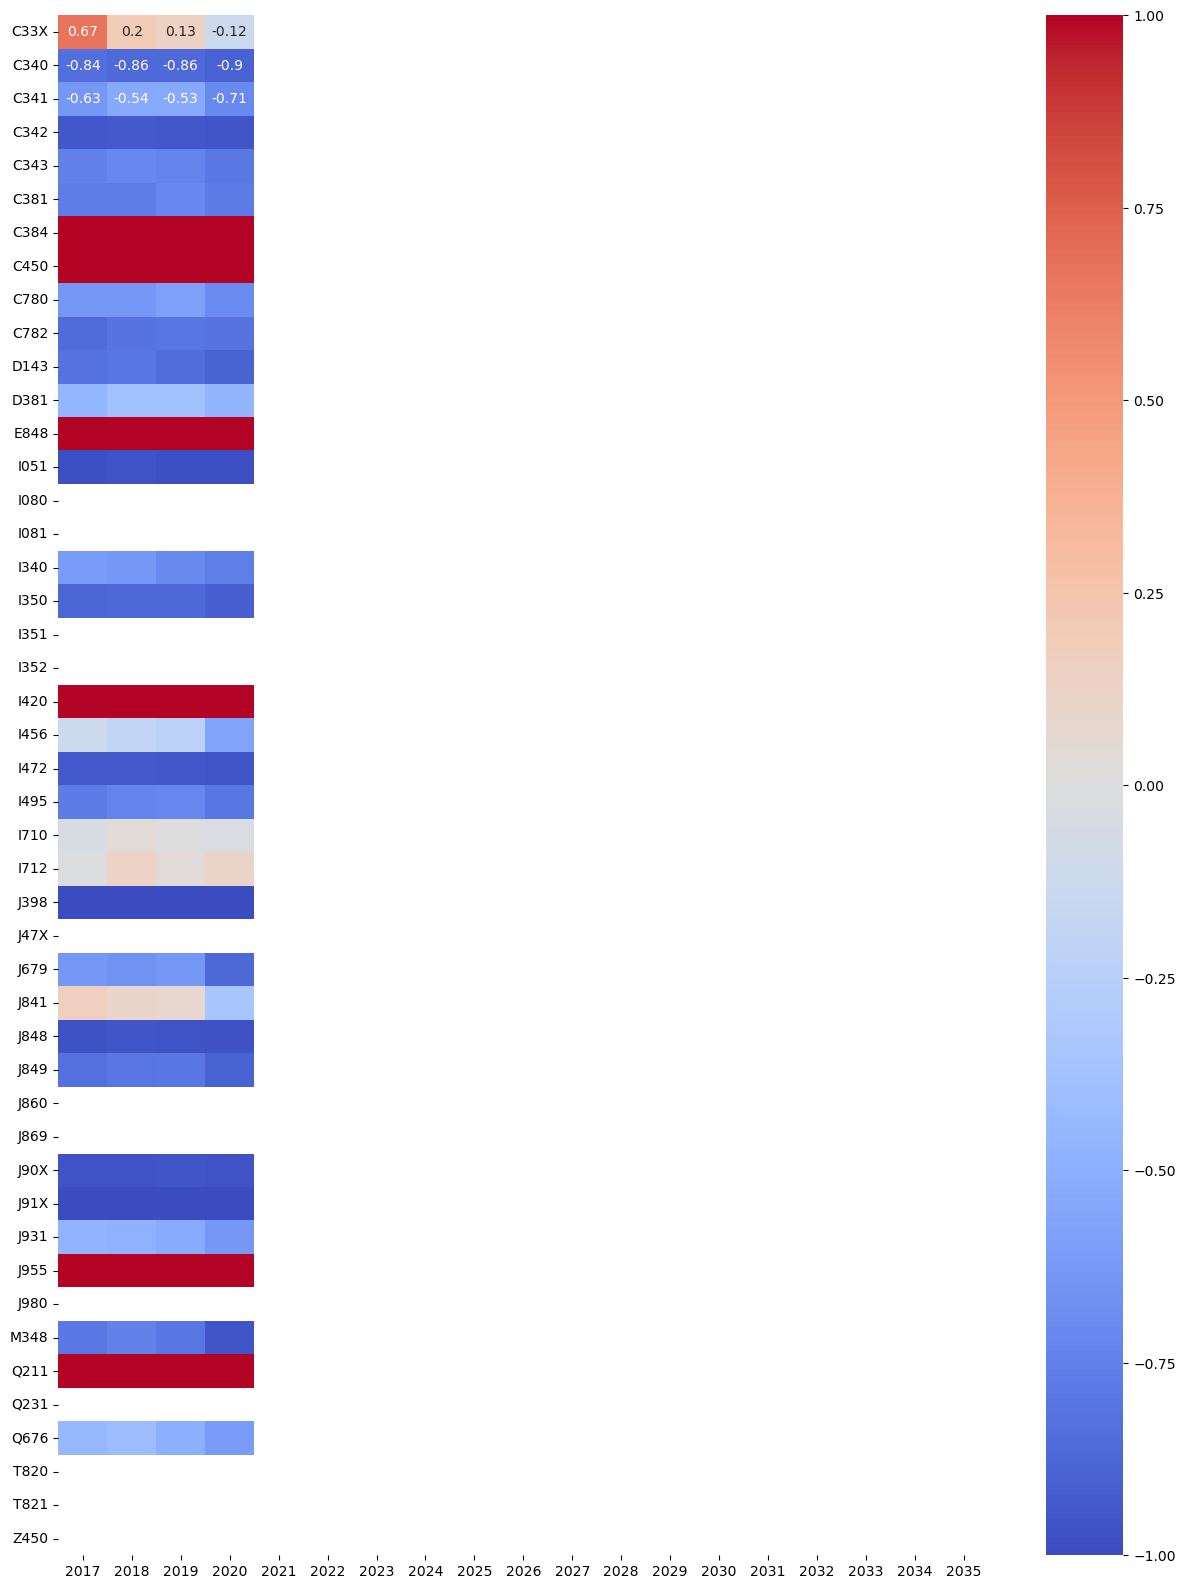

In [50]:
fig, axis = plt.subplots(1, 1, figsize=(15, 20))
sns.heatmap(brecha_pais, ax=axis, center=0, vmin=-1, vmax=1, cmap="coolwarm", annot=True)